<a href="https://colab.research.google.com/github/JanaDeCoster/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Kaggle_eye_blinking_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd;
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import seaborn as sns;
from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.linear_model import LinearRegression;
from sklearn import metrics;
from sklearn import linear_model;
from sklearn.linear_model import LogisticRegression;
from sklearn.model_selection import cross_val_score;
from sklearn.model_selection import GridSearchCV;
from sklearn.pipeline import Pipeline;
from sklearn.preprocessing import PolynomialFeatures;
from sklearn.model_selection import cross_val_predict;
from sklearn import preprocessing;
from sklearn.preprocessing import RobustScaler;
from sklearn.svm import SVC;
from sklearn.ensemble import AdaBoostClassifier;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.datasets import make_classification;
import xgboost as xgb;
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error;
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split;


# **Eye blinking prediction**

The goal of this project is to find a model that wil be trained on a train dataset and that will perform well on the test dataset. The results of fitting this model on the test dataset will be scored in Kaggle to see how well the predictions of the model are.

The following data will be used as test- and train datasets.

In [0]:
trainset_unprocessed = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset_unprocessed = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

In [3]:
print(trainset_unprocessed.head())
print(testset_unprocessed.head())

       AF3       F7       F3      FC5  ...       F4       F8      AF4  label
0  4299.49  3997.44  4277.95  4116.92  ...  4278.97  4600.00  4369.23      1
1  4302.05  3985.64  4261.03  4129.74  ...  4283.08  4607.18  4358.46      0
2  4321.03  4015.90  4265.13  4122.56  ...  4286.15  4608.21  4371.79      0
3  4408.21  4104.10  4380.00  4232.31  ...  4388.21  4715.90  4464.10      0
4  4347.18  3975.38  4266.67  4102.56  ...  4313.33  4664.10  4411.79      1

[5 rows x 15 columns]
       AF3       F7       F3      FC5  ...       F4       F8      AF4  index
0  4296.41  4040.51  4253.33  4124.10  ...  4268.72  4598.46  4342.56      0
1  4291.28  3994.36  4247.18  4102.56  ...  4260.51  4593.33  4337.95      1
2  4299.49  4019.49  4269.74  4116.41  ...  4280.51  4596.92  4350.26      2
3  4280.00  4004.62  4263.59  4120.51  ...  4271.79  4608.72  4344.10      3
4  4317.44  3968.72  4260.51  4101.54  ...  4282.05  4592.31  4372.82      4

[5 rows x 15 columns]


Before we can standardize the data we first have to pop the label column of the trainset and the index column of the testset since these do not need to be standardized.

In [0]:
label = trainset_unprocessed.pop('label')
index = testset_unprocessed.pop('index')

## **Pre-processing**

The first step in this process would be to pre-process or standardize. This has to be done since feature values can have different scales (meaning different minimum and different maximum values). 

So we will do this for both our datasets (test- and train dataset).


We will first plot the unprocessed train dataset to see how the results are spread for the different features.

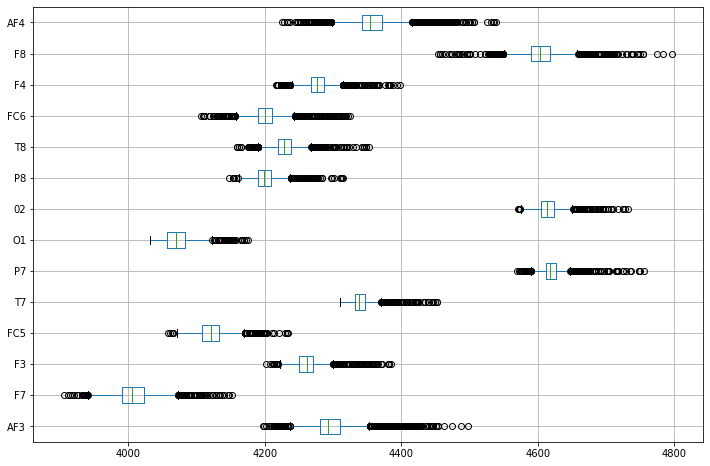

In [5]:
plt.figure(figsize=(12,8))
trainset_unprocessed.boxplot(vert=False)
plt.show()

This plot shows us that data normalization will most defenitly be necessary.

As we have seen in the lessons, this normalization can either be done by standardization or by scaling the data (but there are even more options such as a robust scaler)

We will just plot both of these aproaches to visualize how this actually works.


Firts we will try **standardization**. This method scales the features such that they will have the properties of a normal distribution ($\mu = 0$ and $\sigma = 1$). 

\begin{equation} x_{norm} = \frac{x - \mu}{\sigma}\end{equation} 


We will normalize our data using this approach and visualize the result.

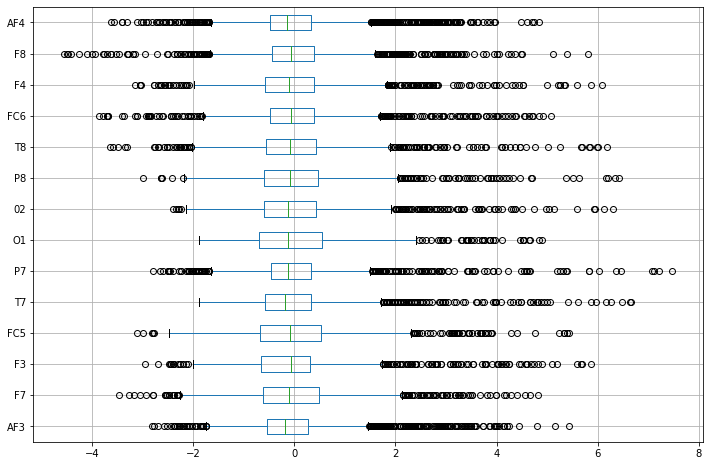

In [6]:
trainset_unprocessed_columns = trainset_unprocessed.columns.values
scaler = StandardScaler()
scaler.fit(trainset_unprocessed)
trainset_stand = pd.DataFrame(scaler.transform(trainset_unprocessed),columns=trainset_unprocessed_columns)
plt.figure(figsize=(12,8))
trainset_stand.boxplot(vert=False)
plt.show()

The other method we can use is the **scaling method**. This uses the following equation:
 \begin{equation} x_{norm} = \frac{x - x_{min}}{x_{max}-x_{min}} \end{equation}
In this equation $x_{min}$ and $x_{max}$ represent the minimum and maximum values respectively.

We can again visualize the data that is now normalized using the scaling method.

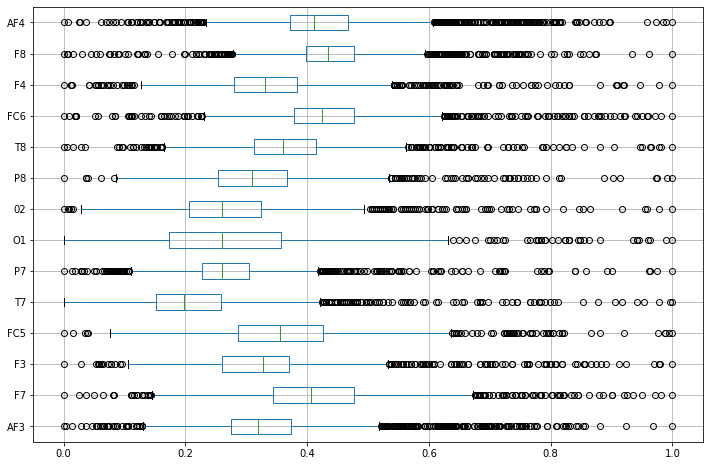

In [7]:
trainset_unprocessed_columns = trainset_unprocessed.columns.values
scaler_min_max = MinMaxScaler()
scaler_min_max.fit(trainset_unprocessed)
trainset_scaling = pd.DataFrame(scaler_min_max.transform(trainset_unprocessed),columns=trainset_unprocessed_columns)
plt.figure(figsize=(12,8))
trainset_scaling.boxplot(vert=False)
plt.show()

We can see that the standardization method normalizes the data more evenly. The scaling method still provides good results but the feature results are more spread compared to the standardization method.

Based on the more centered results, the standardization method will be used.

We now will fit and transform the train dataset and transform the test dataset.

In [9]:
scaler = StandardScaler()

scaler.fit(trainset_unprocessed)

trainset_norm = pd.DataFrame(scaler.transform(trainset_unprocessed), columns = trainset_unprocessed.columns)
testset_norm = pd.DataFrame(scaler.transform(testset_unprocessed), columns = testset_unprocessed.columns)

print(trainset_norm.shape)
print(testset_norm.shape)

(2000, 14)
(12892, 14)


Now we can add the label and index again to these datasets and take a look at  the standardized data.


In [10]:
trainset_norm['label'] = label
testset_norm['index'] = index

print(trainset_norm)
print(testset_norm)

           AF3        F7        F3  ...        F8       AF4  label
0    -0.018351 -0.396476  0.677912  ... -0.156365  0.252992      1
1     0.052070 -0.791842 -0.136210  ...  0.060820 -0.037576      0
2     0.574178  0.222036  0.061066  ...  0.091976  0.322059      0
3     2.972354  3.177226  5.588146  ...  3.349453  2.812530      0
4     1.293521 -1.135609  0.135164  ...  1.782573  1.401236      1
...        ...       ...       ...  ...       ...       ...    ...
1995 -2.430832  0.222036 -1.616738  ... -1.831536 -2.555566      1
1996 -0.864783  0.874724 -1.246726  ... -0.559580 -1.033657      0
1997 -0.342950 -0.053044  0.159704  ... -0.233802 -0.175981      0
1998 -0.060714  0.754439  0.579275  ... -0.032346 -0.521857      0
1999  0.080403  0.033065  0.332440  ...  0.650366 -0.286596      0

[2000 rows x 15 columns]
            AF3        F7        F3  ...        F8       AF4  index
0     -0.103077  1.046608 -0.506702  ... -0.202948 -0.466549      0
1     -0.244195 -0.499673 -0.80261

## **Models**

After pre-processing the data, model can be made to make predictions about the data. But before we can do that we will have a look how the data is plotted against each other, because we cannot make a model without first making some assumptions.

### **Plots**

We will randomly select features from the traindataset and plot them against each other.

These are the results:

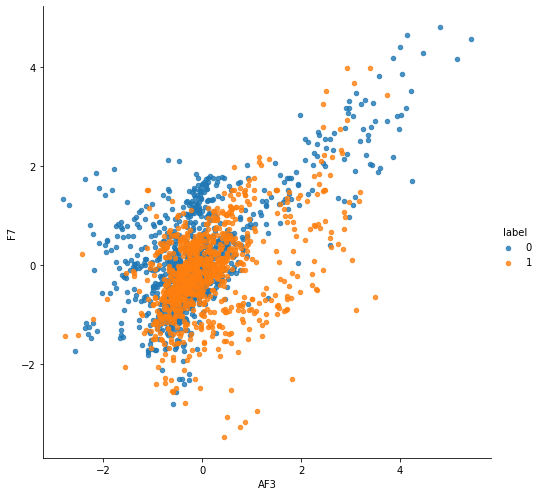

In [11]:
sns.lmplot(x="AF3", y="F7", hue = 'label', data=trainset_norm, fit_reg=False, height=7, scatter_kws={"s": 20})

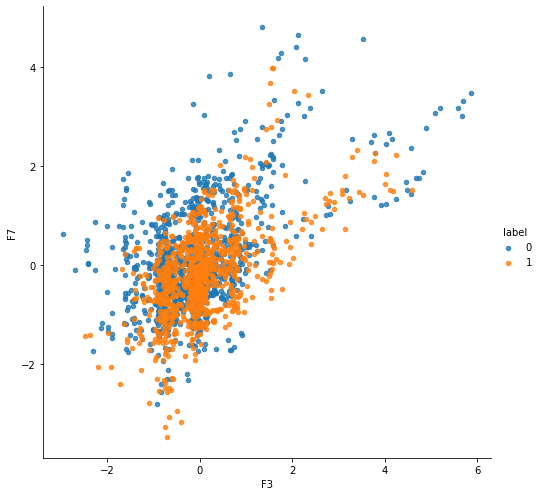

In [12]:
sns.lmplot(x="F3", y="F7", hue = 'label', data=trainset_norm, fit_reg=False, height=7, scatter_kws={"s": 20})

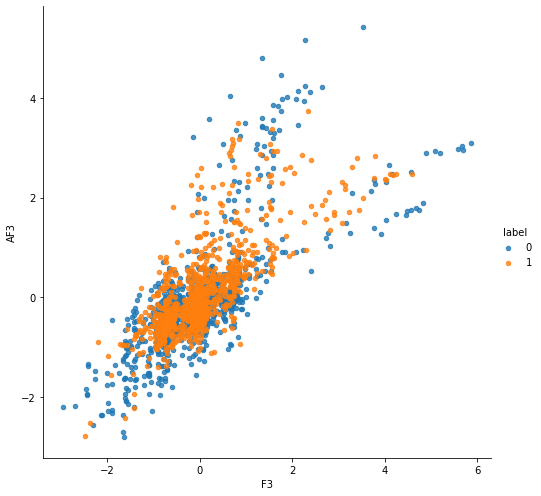

In [13]:
sns.lmplot(x="F3", y="AF3", hue = 'label', data=trainset_norm, fit_reg=False, height=7, scatter_kws={"s": 20})

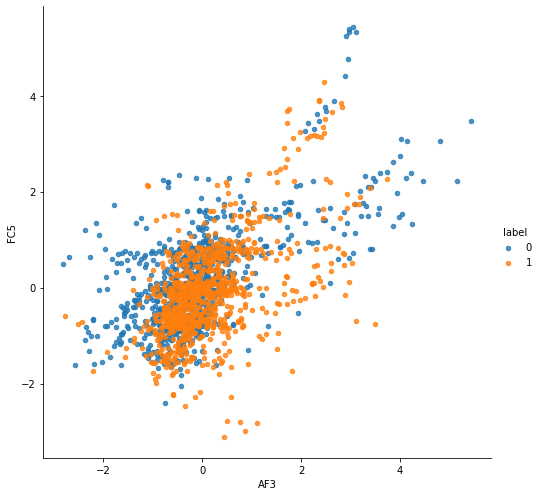

In [14]:
sns.lmplot(x="AF3", y="FC5", hue = 'label', data=trainset_norm, fit_reg=False, height=7, scatter_kws={"s": 20})

We can clearly see that the features overlap for a large part. This would also sugggest that a classification model would be necessary to make good predictions about the test set.



As we have seen in the lessons, many different kind of classification models can be used. The first approach we will look into is the Suport Vector Machines.

### **Suport Vector Machines**

#### **A bit of backgroud:**




**Support vector machines (SVMs)** work based on a **linear classifictation model**. This means that this model can be used to seperate data that is linearly seperable. But this does not mean that this model is the same as a logistic model, there are some differences.
First of all, the mathematical aspect is different. In contrast to a logistic regression model, SVMs allow for an **intuitive regularization of the model**. Beside this difference, SVMs allow for the transformation of **a linear to a non-linear decision boundarie** which is achieved by using what is know as a **kernel function**.


Before we start by making our model, we will first define our X and y values that will be used throughout this entire project.

In [0]:
X = trainset_norm
y = X.pop('label')

X_test = testset_norm
y_test = X_test.pop('index')

#### **Creating the model**

Now that we defined these values we can start by making our first model for which we will use a 'rbf' Kernel function.

In [69]:
model = SVC(kernel='rbf',C=1,gamma=1)
model.fit(X,y)
score_auc = cross_val_score(model, X, y, scoring = 'roc_auc', cv = 10).mean()
print(score_auc)

0.9581062148860315


We can see that we already get a very high **AUC score**. The higher this score is, the  better the classification performance of the model. This score represent the percentage of the area under the **ROC curve** which plots the true positive rate against the false positive rate. Idealy, the true positive rate would be 1 and the false positive rate would be 0.

#### **Optimalization of the model**

The next step would be to try to optimize this model as much as possible.

Each model has **hyperparameters**. These are the parameters of your model that are set prior to the start of the learning process. By adjusting these hyperparameters the model can be optimized.

To optimize the model we will try to look for the best possible value of ***C***, the regularization parameter (hyperparameter).

In [17]:
search_space = np.logspace(-10, 14, 10, base=2)

params = dict(C=search_space)
grid_search = GridSearchCV(model, param_grid=params, iid=False)

grid_search.fit(X, y)

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean_score, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("{:.3f} (+/-{:.3f}) for {}".format(mean_score, std * 2, params))

print(grid_search.best_estimator_)

0.550 (+/-0.002) for {'C': 0.0009765625}
0.550 (+/-0.002) for {'C': 0.006200785359250777}
0.550 (+/-0.002) for {'C': 0.03937253280921478}
0.689 (+/-0.046) for {'C': 0.25}
0.911 (+/-0.025) for {'C': 1.587401051968199}
0.908 (+/-0.026) for {'C': 10.079368399158977}
0.908 (+/-0.026) for {'C': 64.0}
0.908 (+/-0.026) for {'C': 406.3746693038584}
0.908 (+/-0.026) for {'C': 2580.318310184698}
0.908 (+/-0.026) for {'C': 16384.0}
SVC(C=1.587401051968199, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


We can see that a value of **1.587401051968199** would be ideal for ***C***.

We can nog readjust the model with this optimalized regularization parameter and see if the AUC score increases.

In [18]:
model = SVC(kernel='rbf',C=1.587401051968199,gamma=1, probability=True)
model.fit(X,y)
score_auc = cross_val_score(model, X, y, scoring = 'roc_auc', cv = 10).mean()
print(score_auc)

0.9629143150427554


We get an AUC score of **0.9629143150427554**, this is an increase compared to our previous model. 


#### **Predictions and results**

Now that we optimized the model, we can start to make some predictions on the test dataset:

In [19]:
predictions = model.predict_proba(X_test)[:,1]
print(predictions)

[0.00316856 0.47180379 0.00477617 ... 0.92323162 0.95695912 0.00407401]


We will put these predictions into a submission file so we can evaluate our model in Kaggle.

In [20]:
sample_submission_svm = pd.DataFrame(columns = ['index', 'label'])
sample_submission_svm['index'] = y_test
sample_submission_svm['label'] = predictions
sample_submission_svm.head()

,index,label
0,0,0.003169
1,1,0.471804
2,2,0.004776
3,3,0.999983
4,4,0.953290


In [0]:
filename = "DeCosterJana_prediction_SVM2.csv"

sample_submission_svm.to_csv(filename,index=False)

***The Results:***

This model gives a score of **0.97067**. This is a very good score, as was expected by the AUC score. 

The next step in this project would be to see if we can find a model that performs even better than this one.

### **DiciscionTree model**

#### **A bit of backgroud:**

A **deciscion tree** is a combination of nodes and branches, in which the **nodes** represent a test on a feature and a **branch** represents the possible outcome of a test. The end-nodes are called the leaf nodes and these represent a target. The flow of a deciscion tree is from the root-node (the first test) to the leaf nodes. 
To find the best path in this deciscion tree, entropy is calculated. Entropy represents the impurity of the class label probabilities. To fnd thge best path, this entopy has to be as low as possible.

A deciscion tree model is based on this principle which gives this model some advantages such as the ease of interpretation and a low bias. But with the advantages also come the disadvantages of high variance and overfitting.



#### **Creating the model**

Now we will see how well a DecisionTree model would perfom on our data.

In [75]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X, y)
score_auc = cross_val_score(model, X, y, scoring = 'roc_auc', cv = 10).mean()
print(score_auc)

0.9249849732326798


We can already see that this AUC score is lower than our AUC score of the SVM model we created earlier. But nevertheless, this remains a very good AUC score. 

#### **Optimalization of the model**

Now we will try to optimize this model. We will do this by varying four different hyperparameters. 

These hyperparameters are:

1: *n_estimators*: This hyperparameter specifies the number of trees in the forest of the model.

2: *max_depth*: This hyperparameter specifies the maximum depth of each tree.

3: *min_samples_split*: This hyperparameter specifies the minimum number of samples required to split an internal leaf node.

4: *min_samples_leaf*: This hyperparameter specifies the minimum number of samples required to be at a leaf node. 

Finding the optimal value for each of these four parameters obviously will take quite some time, but in the end the model will be optimalized and the results will be better.

In [0]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 


model = RandomForestClassifier(n_jobs=-1)
params = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid_search = GridSearchCV(model, param_grid=params, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_estimator_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min


We can see that a number of 100 estimators would be ideal combined with a maximum of 14 features.

We can now readjust the model with these parameters and then we can see if there is an increase in AUC score.

In [81]:
model = RandomForestClassifier(n_estimators=100, max_features=14, n_jobs=-1)
model.fit(X, y)

score_auc = cross_val_score(model, X, y, scoring = 'roc_auc', cv = 10).mean()
print(score_auc)

0.9230702320105989


We can only see a slight increase in AUC scorewhich would suggest that the model is only slightly more optimal.

#### **Predictions and results**

In [78]:
predictions = model.predict_proba(X_test)[:,1]
predictions

array([0.05, 0.33, 0.08, ..., 0.94, 0.83, 0.18])

In [79]:
sample_submission_dt = pd.DataFrame(columns = ['index', 'label'])
sample_submission_dt['index'] = y_test
sample_submission_dt['label'] = predictions
sample_submission_dt.head()

,index,label
0,0,0.05
1,1,0.33
2,2,0.08
3,3,0.98
4,4,0.96


In [0]:
filename = "DeCosterJana_prediction_clf2.csv"

sample_submission_dt.to_csv(filename,index=False)